In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/covid19-global-forecasting-week-2/train.csv
/kaggle/input/covid19-global-forecasting-week-2/submission.csv
/kaggle/input/covid19-global-forecasting-week-2/test.csv


In [2]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor

path_train = '../input/covid19-global-forecasting-week-2/train.csv'
path_test = '../input/covid19-global-forecasting-week-2/test.csv'

covid_train = pd.read_csv(path_train)
covid_test = pd.read_csv(path_test, index_col='ForecastId')

print("Train len: %d, Test len: %d" %(len(covid_train), len(covid_test)))

Train len: 20580, Test len: 12642


In [3]:
def inDay(col):
    '''get new register in day of Confirmed Cases or Fatalities'''
    inDay=[]
    for i in range(len(covid_train)):
        if i==0 or covid_train['Country_Region'][i]!=covid_train['Country_Region'][i-1] or (not pd.isna(covid_train['Province_State'][i]) and not pd.isna(covid_train['Province_State'][i-1]) and covid_train['Province_State'][i]!=covid_train['Province_State'][i-1]) or pd.isna(covid_train['Province_State'][i])!=pd.isna(covid_train['Province_State'][i-1]) :
            inDay.append(covid_train[col][i])
        else:
            inDay.append(covid_train[col][i]-covid_train[col][i-1])
    return pd.DataFrame(inDay)

In [4]:
covid_train['ConfirmedCasesInDay'] = inDay('ConfirmedCases')
covid_train['FatalitiesInDay'] = inDay('Fatalities')

In [5]:
covid_train['Date'] = pd.to_datetime(covid_train['Date'])

In [6]:
covid_train.describe()

,Id,ConfirmedCases,Fatalities,ConfirmedCasesInDay,FatalitiesInDay
count,20580.000000,20580.000000,20580.000000,20580.000000,20580.000000
mean,14685.500000,514.939116,21.080952,41.644752,2.045627
std,8487.230117,4541.261768,287.758197,362.004059,28.061109
min,1.000000,0.000000,0.000000,-62.000000,-5.000000
25%,7335.750000,0.000000,0.000000,0.000000,0.000000
50%,14685.500000,0.000000,0.000000,0.000000,0.000000
75%,22035.250000,35.000000,0.000000,1.000000,0.000000
max,29370.000000,105792.000000,12428.000000,14840.000000,919.000000


Have some Confirmed Cases and Fatilities with the wrong register, that cause 'InDay' less than zero

In [7]:
covid_train[covid_train['FatalitiesInDay']<0].head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ConfirmedCasesInDay,FatalitiesInDay
3140,4461,Quebec,Canada,2020-03-22,219.0,4.0,38.0,-1.0
9364,13355,NaN,Iceland,2020-03-16,180.0,0.0,9.0,-5.0
9368,13359,NaN,Iceland,2020-03-20,409.0,0.0,79.0,-1.0
9439,13460,NaN,India,2020-03-21,330.0,4.0,86.0,-1.0
10139,14460,NaN,Kazakhstan,2020-03-21,53.0,0.0,4.0,-3.0


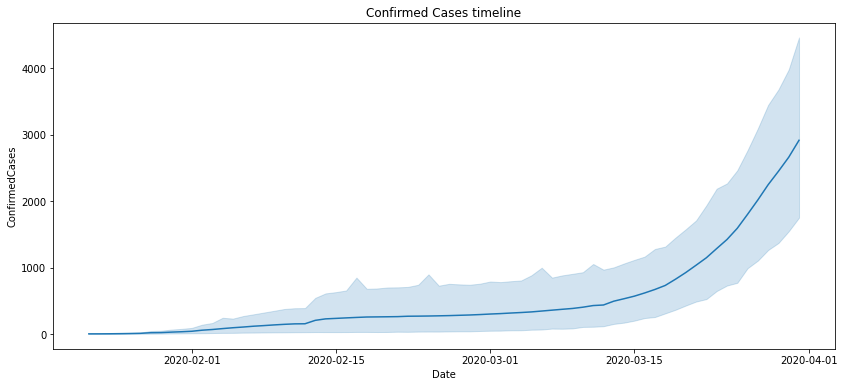

In [8]:
plt.figure(figsize=(14,6))
plt.title('Confirmed Cases timeline')
sns.lineplot(y=covid_train['ConfirmedCases'], x=covid_train['Date'])

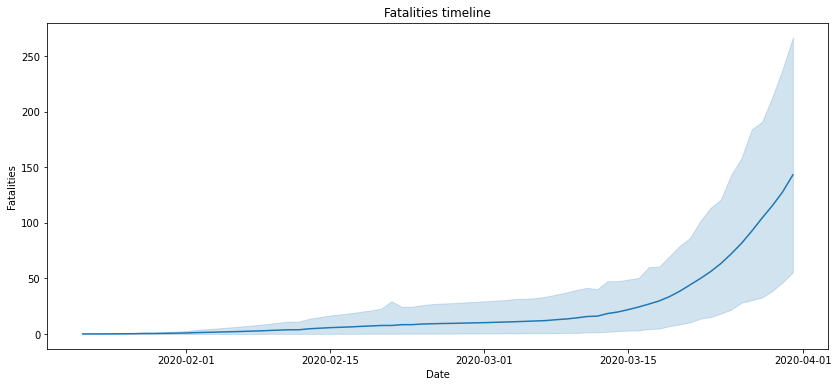

In [9]:
plt.figure(figsize=(14,6))
plt.title('Fatalities timeline')
sns.lineplot(y=covid_train['Fatalities'], x=covid_train['Date'])

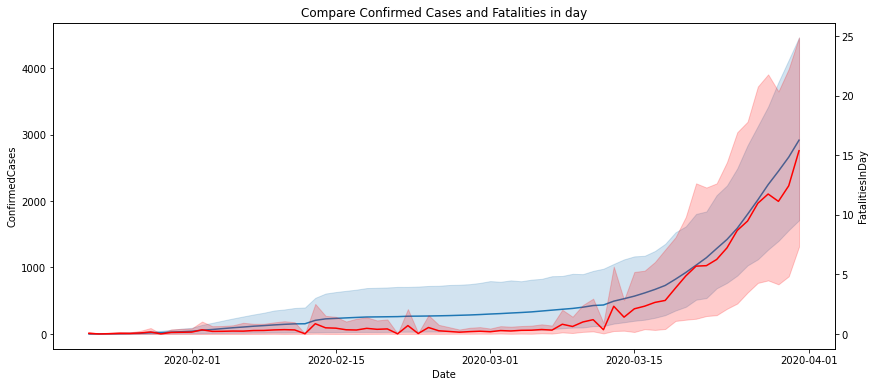

In [10]:
plt.figure(figsize=(14,6))
plt.title('Compare Confirmed Cases and Fatalities in day')
pl = sns.lineplot(y=covid_train['ConfirmedCases'], x=covid_train['Date'])
pl2 = pl.twinx()
sns.lineplot(y=covid_train['FatalitiesInDay'], x=covid_train['Date'], ax=pl2, color="r")

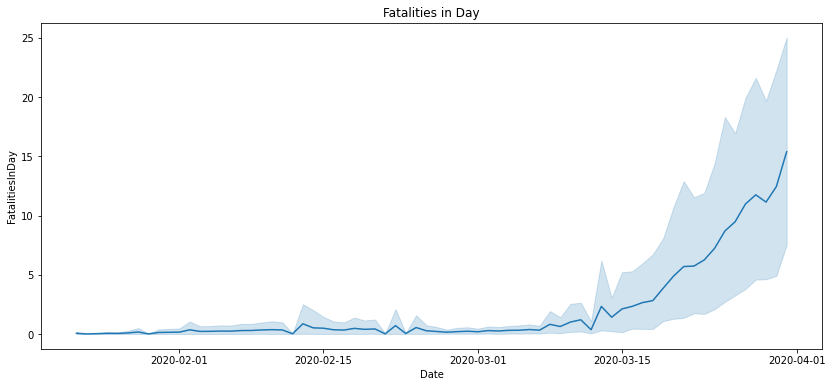

In [11]:
plt.figure(figsize=(14,6))
plt.title('Fatalities in Day')
sns.lineplot(y=covid_train['FatalitiesInDay'], x=covid_train['Date'])

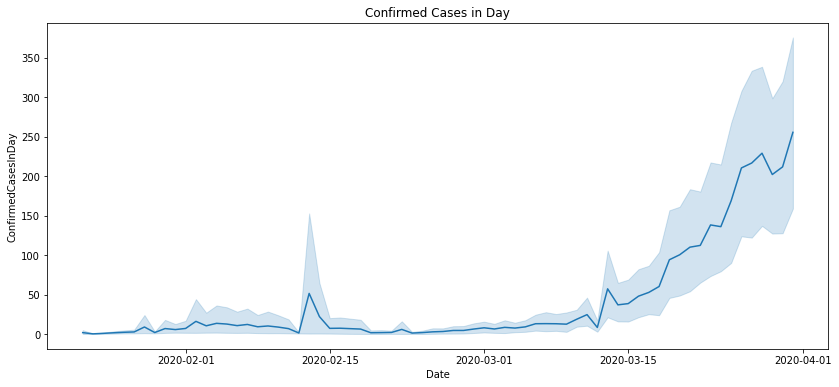

In [12]:
plt.figure(figsize=(14,6))
plt.title('Confirmed Cases in Day')
sns.lineplot(y=covid_train['ConfirmedCasesInDay'], x=covid_train['Date'])

# Analyze Occurence per Country

In [13]:
'''
Create new database merge data by Country_Region
'''
occurence_per_country=[]
for country in covid_train['Country_Region'].unique():
    country_data = covid_train[covid_train['Country_Region']==country]
    register_date = country_data[country_data['ConfirmedCases']>0]
    if len(register_date)>0:
        date_cc = register_date.iloc[0]['Date']
    else:
        data_cc = np.nan
        
    register_date = country_data[country_data['Fatalities']>0]
    if len(register_date):
        date_ft = register_date.iloc[0]['Date']
    else:
        date_ft = np.nan
    #get all max of province state and sum to have the total in country
    max_cc=0
    max_ft=0
    for province_state in country_data['Province_State'].unique():
        if not pd.isna(province_state):
            province_state_data=country_data[country_data['Province_State']==province_state]
        else:
            province_state_data=country_data[pd.isna(country_data['Province_State'])]
        max_cc+=max(province_state_data['ConfirmedCases'])
        max_ft+=max(province_state_data['Fatalities'])
            
    country_data_new = [country,
                        date_cc, date_ft,
                        max_cc, max_ft, 
                        max(country_data['ConfirmedCasesInDay']), max(country_data['FatalitiesInDay'])]
    occurence_per_country.append(country_data_new)
occurence_per_country = pd.DataFrame(occurence_per_country)

In [14]:
occurence_per_country.columns = ['Country_Region', 'FirstRegisterConfirmedCase', 'FirstRegisterFatalities',
                                'ConfirmedCasesMax', 'FatalitiesMax', 'ConfirmedCasesInDayMax', 'FatalitiesInDayMax']

In [15]:
occurence_per_country.head()

,Country_Region,FirstRegisterConfirmedCase,FirstRegisterFatalities,ConfirmedCasesMax,FatalitiesMax,ConfirmedCasesInDayMax,FatalitiesInDayMax
0,Afghanistan,2020-02-24,2020-03-22,174.0,4.0,50.0,2.0
1,Albania,2020-03-09,2020-03-11,243.0,15.0,28.0,4.0
2,Algeria,2020-02-25,2020-03-12,716.0,44.0,132.0,9.0
3,Andorra,2020-03-02,2020-03-22,376.0,12.0,43.0,4.0
4,Angola,2020-03-20,2020-03-29,7.0,2.0,2.0,2.0


In [16]:
occurence_per_country.describe()

,ConfirmedCasesMax,FatalitiesMax,ConfirmedCasesInDayMax,FatalitiesInDayMax
count,173.000000,173.000000,173.000000,173.000000
mean,4954.092486,243.381503,494.809249,26.716763
std,20203.173477,1249.458913,1780.803197,114.171004
min,1.000000,0.000000,1.000000,0.000000
25%,20.000000,0.000000,6.000000,0.000000
50%,212.000000,3.000000,39.000000,2.000000
75%,1109.000000,20.000000,181.000000,6.000000
max,188018.000000,12428.000000,14840.000000,919.000000


The countries with the biggest number of Fatalities:

In [17]:
occurence_per_country[occurence_per_country['FatalitiesMax']==max(occurence_per_country['FatalitiesMax'])]

,Country_Region,FirstRegisterConfirmedCase,FirstRegisterFatalities,ConfirmedCasesMax,FatalitiesMax,ConfirmedCasesInDayMax,FatalitiesInDayMax
81,Italy,2020-01-31,2020-02-21,105792.0,12428.0,6557.0,919.0


5 countries whith less Fatalities

In [18]:
occurence_per_country[occurence_per_country['FatalitiesMax']==min(occurence_per_country['FatalitiesMax'])].head()

,Country_Region,FirstRegisterConfirmedCase,FirstRegisterFatalities,ConfirmedCasesMax,FatalitiesMax,ConfirmedCasesInDayMax,FatalitiesInDayMax
5,Antigua and Barbuda,2020-03-13,NaT,7.0,0.0,4.0,0.0
11,Bahamas,2020-03-16,NaT,14.0,0.0,4.0,0.0
14,Barbados,2020-03-17,NaT,34.0,0.0,8.0,0.0
17,Belize,2020-03-23,NaT,3.0,0.0,1.0,0.0
18,Benin,2020-03-16,NaT,9.0,0.0,3.0,0.0


# Top 10 countries with more Fatalities

In [19]:
largest_fatalities = occurence_per_country.nlargest(10, 'FatalitiesMax')

In [20]:
largest_fatalities.head()

,Country_Region,FirstRegisterConfirmedCase,FirstRegisterFatalities,ConfirmedCasesMax,FatalitiesMax,ConfirmedCasesInDayMax,FatalitiesInDayMax
81,Italy,2020-01-31,2020-02-21,105792.0,12428.0,6557.0,919.0
147,Spain,2020-02-01,2020-03-03,95923.0,8464.0,9630.0,913.0
162,US,2020-03-13,2020-03-25,188018.0,3871.0,9170.0,332.0
58,France,2020-03-07,2020-03-22,52827.0,3532.0,7578.0,499.0
33,China,2020-01-22,2020-02-09,82280.0,3309.0,14840.0,242.0


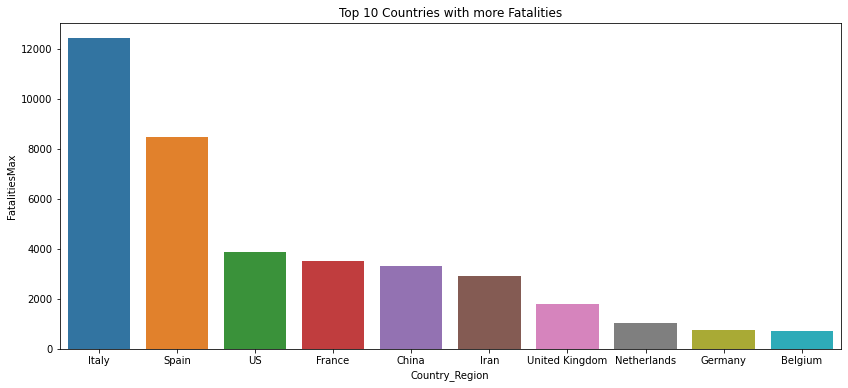

In [21]:
plt.figure(figsize=(14,6))
plt.title('Top 10 Countries with more Fatalities')
sns.barplot(y=largest_fatalities['FatalitiesMax'], x=largest_fatalities['Country_Region'])

# Top 10 countries with more Confirmed Cases

In [22]:
largest_confirmed_cases = occurence_per_country.nlargest(10, 'ConfirmedCasesMax')

In [23]:
largest_confirmed_cases.head()

,Country_Region,FirstRegisterConfirmedCase,FirstRegisterFatalities,ConfirmedCasesMax,FatalitiesMax,ConfirmedCasesInDayMax,FatalitiesInDayMax
162,US,2020-03-13,2020-03-25,188018.0,3871.0,9170.0,332.0
81,Italy,2020-01-31,2020-02-21,105792.0,12428.0,6557.0,919.0
147,Spain,2020-02-01,2020-03-03,95923.0,8464.0,9630.0,913.0
33,China,2020-01-22,2020-02-09,82280.0,3309.0,14840.0,242.0
62,Germany,2020-01-27,2020-03-09,71808.0,775.0,6933.0,130.0


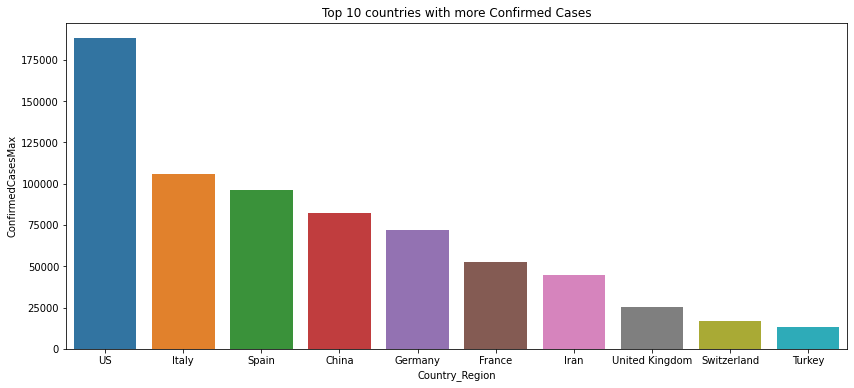

In [24]:
plt.figure(figsize=(14,6))
plt.title("Top 10 countries with more Confirmed Cases")
sns.barplot(y=largest_confirmed_cases['ConfirmedCasesMax'], x=largest_confirmed_cases['Country_Region'])

# Model 1 - RandomForestRegressor

In [25]:
X_features = ['Date', 'Country_Region', 'Province_State']
X = covid_train[X_features]

y_cc = covid_train['ConfirmedCases']
y_ft = covid_train['Fatalities']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, ['Country_Region', 'Province_State'])
    ])

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

cc_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestRegressor(n_estimators=100, random_state=0))
                             ])

ft_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestRegressor(n_estimators=100, random_state=0))
                             ])

X_train, X_valid, y_train, y_valid = train_test_split(X, y_cc, random_state=0)
cc_pipeline.fit(X_train, y_train)
preds_cc = cc_pipeline.predict(X_valid).astype(int)

print('MAE to ConfirmedCases:', mean_absolute_error(y_valid, preds_cc))

X_train, X_valid, y_train, y_valid = train_test_split(X, y_ft, random_state=0)
ft_pipeline.fit(X_train, y_train)
preds_ft = ft_pipeline.predict(X_valid).astype(int)

print('MAE to Fatalities:', mean_absolute_error(y_valid, preds_ft))

MAE to ConfirmedCases: 539.9065111758989
MAE to Fatalities: 26.03265306122449


In [27]:
#predict tests
test_preds_cc = cc_pipeline.predict(covid_test[X_features])
test_preds_ft = ft_pipeline.predict(covid_test[X_features])

In [28]:
submission = pd.DataFrame({'ForecastId': covid_test.index,'ConfirmedCases':test_preds_cc,'Fatalities':test_preds_ft})
filename = 'submission.csv'

submission.to_csv(filename,index=False)